# WGAN on CIFAR-10

# Setup imports and hyperparameters

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from itertools import cycle
from tqdm import tqdm  # for displaying progress bar

In [ ]:
# Install extra package if FID is needed
!pip install pytorch-fid
from pytorch_fid import fid_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
# Hyperparameters from the table
z_dim = 100  # Size of the noise vector
lr = [0.0001, 0.0002, 0.0003]  # Learning rate for Adam optimizer
betas = (0.5, 0.999)  # Betas for Adam optimizer
batch_size = 100
image_size = 32
channels_img = 3
gen_features = 384  # Feature maps for the first layer of generator
disc_features = 16  # Feature maps for the first layer of discriminator
num_epochs = 100  # Assuming 50 for a shorter training time; can be changed to 50000 iterations
leaky_slope = 0.2  # Slope for the leaky ReLU
drop_out = 0.5  # Dropout rate
sigma_noise = 0.05  # Standard deviation for Gaussian noise
n_critic = 5  # Number of critic updates per generator update
clip_value = 0.01  # Clip value for the critic

# Define two DNNs

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super(Generator, self).__init__()

        # Define individual layers to access their output for printing
        self.init_linear = nn.Linear(z_dim, 384 * 4 * 4, bias=False)
        self.init_relu = nn.ReLU(True)

        self.conv_transpose1 = nn.ConvTranspose2d(384, 192, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(192)
        self.relu1 = nn.ReLU(True)

        self.conv_transpose2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.relu2 = nn.ReLU(True)

        self.conv_transpose3 = nn.ConvTranspose2d(96, img_channels, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, noise):
        # Concatenate label embedding with noise
        gen_input = noise

        # Pass through initial linear layer and activation
        out = self.init_linear(gen_input)
        out = self.init_relu(out)
        out = out.view(out.size(0), 384, 4, 4)  # Reshape to (batch_size, 384, 4, 4)
        # print("After initial linear layer:", out.shape)

        # Pass through first transposed convolution layer
        out = self.conv_transpose1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        # print("After first ConvTranspose2d:", out.shape)

        # Pass through second transposed convolution layer
        out = self.conv_transpose2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        # print("After second ConvTranspose2d:", out.shape)

        # Pass through third transposed convolution layer
        out = self.conv_transpose3(out)
        out = self.tanh(out)
        # print("After third ConvTranspose2d:", out.shape)

        return out

In [4]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float): Standard deviation of the Gaussian noise.
    """
    def __init__(self, sigma=0.05):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x

class Critic(nn.Module):
    def __init__(self, gaussian_noise, img_channels):
        super(Critic, self).__init__()
        self.noise = GaussianNoise(gaussian_noise)

        # Discriminator's Convolutional Layers with kernel size and stride as arguments
        self.main = nn.Sequential(
            # Input is 32 x 32 x img_channels
            nn.Conv2d(img_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),    # State size: 16 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),    # State size: 32 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),   # State size: 64 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),  # State size: 128 x 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),  # State size: 256 x 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Flatten()
        )

        # Output head for real/fake classification
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = self.noise(img)
        # Pass the input image through the feature extractor
        features = self.main(img)

        # Pass the features through the two heads
        real_fake = self.adv_layer(features)

        return real_fake

# Initialize models

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif 'BatchNorm' in classname:
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0)
    elif "Linear" in classname:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

In [10]:
# Transformations for the input data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load the CIFAR-10 dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split CIFAR-10 into training and testing sets
train_size = int(0.9 * len(full_dataset))  # 90% for training
validation_size = len(full_dataset) - train_size  # 10% for validation
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Initialize Generator and Critic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(z_dim, channels_img).to(device)
critic = Critic(sigma_noise, channels_img).to(device)

# Load pre-trained models

generator.load_state_dict(torch.load('/content/drive/MyDrive/ECE661/Project/WGAN/Apr22Tests/generator.pth'))
critic.load_state_dict(torch.load('/content/drive/MyDrive/ECE661/Project/WGAN/Apr22Tests/critic.pth'))


# Initialize weights
'''
generator.apply(weights_init)
critic.apply(weights_init)
'''

# Binary Cross Entropy loss and auxiliary classification loss
adversarial_loss = nn.BCELoss().to(device)

# Setup Adam optimizers for both G and C
optimizer_G = optim.Adam(generator.parameters(), lr=lr[0], betas=betas)
optimizer_C = optim.Adam(critic.parameters(), lr=lr[0] / 2, betas=betas)

Files already downloaded and verified


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train WGAN

In [ ]:
# Record training process for later use
G_loss = []
C_loss = []
C_val_loss = []
G_grad = []
C_grad = []
FID = []

In [ ]:
# Change learning rate manually
optimizer_G = optim.Adam(generator.parameters(), lr=lr[0] / 2, betas=betas)
optimizer_C = optim.Adam(critic.parameters(), lr=lr[0] / 2, betas=betas)

In [ ]:
# Initialize settings before start training
validation_iterator = cycle(validation_dataloader)
os.makedirs("generated_images", exist_ok=True)
os.makedirs("real_images", exist_ok=True)
real_images_path = "./real_images"
generated_images_path = "./generated_images"
real_imgs_save, labels = next(validation_iterator)
vutils.save_image(real_imgs_save[:min(batch_size, 100)], f"{real_images_path}/real_samples.png", normalize=True)
dynamic_lr = lr[0]

In [ ]:
# Training loop
for epoch in range(num_epochs):
    # ------------------------------------------
    # Train the model
    # ------------------------------------------
    if epoch % 40 == 0 and epoch > 1:
        dynamic_lr = dynamic_lr * 0.5
        optimizer_G = optim.Adam(generator.parameters(), lr=dynamic_lr, betas=betas)
        optimizer_C = optim.Adam(critic.parameters(), lr=dynamic_lr / 2, betas=betas)
        print(f"Learning rate changed to {dynamic_lr}")

    #loop = tqdm(dataloader, leave=True)
    #for batch_idx, (real, _) in enumerate(loop):
    G_loss_sum = 0
    C_loss_sum = 0
    G_grad_sum = 0
    C_grad_sum = 0
    num = 0
    for i, (imgs, labels) in enumerate(tqdm(train_dataloader)):

        # Configure input
        real_imgs = imgs.to(device)
        cur_batch_size = real_imgs.size(0)

        # Prepare labels for real and fake images
        real_validity = torch.ones(batch_size, 1, device=device)
        fake_validity = torch.zeros(batch_size, 1, device=device)

        #noise = torch.randn(cur_batch_size, z_dim).to(device)
        #noise = torch.clamp(noise, min=-1, max=1)
        #noise = torch.rand(cur_batch_size, z_dim).to(device)

        # -----------------
        # Train Critic
        # -----------------
        for _ in range(n_critic):
            z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
            fake_imgs = generator(z)
            critic_real = critic(real_imgs).reshape(-1)
            critic_fake = critic(fake_imgs).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            C_loss_sum += loss_critic.item()
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)

            # Calculate gradients
            total_grad_norm_critic = 0
            num_params_critic = 0
            for param in critic.parameters():
                if param.grad is not None:
                    total_grad_norm_critic += param.grad.data.norm(2).item()**2  # Sum of squares
                    num_params_critic += param.grad.data.numel()  # Count the number of elements
            if num_params_critic > 0:
                avg_grad_norm_critic = (total_grad_norm_critic / num_params_critic)**0.5
            else:
                avg_grad_norm_critic = 0
            C_grad_sum += avg_grad_norm_critic

            optimizer_C.step()

            # Clip weights of critic
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        # z = torch.randn(batch_size, z_dim, device=device)
        z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        validity = critic(gen_imgs).reshape(-1)
        g_loss = -torch.mean(validity)
        G_loss_sum += g_loss.item()

        g_loss.backward()

        # Calculate gradients
        total_grad_norm_generator = 0
        num_params_generator = 0
        for param in generator.parameters():
            if param.grad is not None:
                total_grad_norm_generator += param.grad.data.norm(2).item()**2  # Sum of squares
                num_params_generator += param.grad.data.numel()  # Count the number of elements
        if num_params_generator > 0:
            avg_grad_norm_generator = (total_grad_norm_generator / num_params_generator)**0.5
        else:
            avg_grad_norm_generator = 0
        G_grad_sum += avg_grad_norm_generator
        num += 1

        optimizer_G.step()
        '''
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        generator.zero_grad()
        loss_gen.backward()
        optimizer_G.step()
        '''

    # Record the average value of loss function and gradients in 1 epoch
    G_loss.append(G_loss_sum / num)
    C_loss.append(C_loss_sum / (num * n_critic))
    G_grad.append(G_grad_sum / num)
    C_grad.append(C_grad_sum / (num * n_critic))

    # ------------------------------------------
    # Validate the model (critic only)
    # ------------------------------------------
    imgs, labels = next(validation_iterator)

    # Configure input
    real_imgs = imgs.to(device)
    z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
    fake_imgs = generator(z)
    critic_real = critic(real_imgs).reshape(-1)
    critic_fake = critic(fake_imgs).reshape(-1)
    loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
    C_val_loss.append(loss_critic.item())

    # Print the progress
    print(f"[Epoch {epoch}/{num_epochs}] [C loss: {C_loss[-1]}] [G loss: {G_loss[-1]}]")
    print(f"[Validation D loss: {loss_critic.item()}]")

    # Update progress bar
    #loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    #loop.set_postfix(Gen_loss=loss_gen.item(), Critic_loss=loss_critic.item())

    with torch.no_grad():
        # Generate a batch of images
        #sample_z = torch.randn(batch_size, z_dim, device=device)
        sample_z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
        sample_images = generator(sample_z)
        vutils.save_image(sample_images[:min(batch_size, 100)], f"{generated_images_path}/epoch_{0}.png", normalize=True)

    # Compute FID score using saved images
    if epoch % 1 == 0:
        fid = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path],
                                                  batch_size=100, device=device, dims=2048)
        FID.append(fid)
        print(f'FID score at Epoch {epoch}: {fid}')

# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(critic.state_dict(), 'discriminator.pth')

100%|██████████| 450/450 [02:02<00:00,  3.67it/s]


[Epoch 0/100] [C loss: -0.1611010666290919] [G loss: -0.4121804905600018]
[Validation D loss: -0.279745876789093]


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 229MB/s]


  0%|          | 0/1 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


FID score at Epoch 0: 376.78580564221215


100%|██████████| 450/450 [01:58<00:00,  3.78it/s]


[Epoch 1/100] [C loss: -0.2581501071585549] [G loss: -0.3600976539320416]
[Validation D loss: -0.2009839415550232]


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


FID score at Epoch 1: 320.8674410636066


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 2/100] [C loss: -0.24115969455242156] [G loss: -0.3728554054763582]
[Validation D loss: -0.25669020414352417]


100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


FID score at Epoch 2: 329.06768589497784


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 3/100] [C loss: -0.23076415611637963] [G loss: -0.37255794399314457]
[Validation D loss: -0.19500914216041565]


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


FID score at Epoch 3: 276.51005040466174


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 4/100] [C loss: -0.2082346913019816] [G loss: -0.38490611016750337]
[Validation D loss: -0.20105576515197754]


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


FID score at Epoch 4: 250.55619881812794


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 5/100] [C loss: -0.19132921918233237] [G loss: -0.3953494347466363]
[Validation D loss: -0.17707514762878418]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


FID score at Epoch 5: 234.77276700498234


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 6/100] [C loss: -0.17488769086201986] [G loss: -0.4017182120349672]
[Validation D loss: -0.11057960987091064]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


FID score at Epoch 6: 214.27690589154525


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 7/100] [C loss: -0.16445934967199963] [G loss: -0.4048987461460961]
[Validation D loss: -0.07849311828613281]


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


FID score at Epoch 7: 196.48625460222254


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 8/100] [C loss: -0.1607826096084383] [G loss: -0.40670483940177493]
[Validation D loss: -0.05301612615585327]


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


FID score at Epoch 8: 221.039620203594


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 9/100] [C loss: -0.1403946399423811] [G loss: -0.4179173719882965]
[Validation D loss: -0.12450385093688965]


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


FID score at Epoch 9: 228.45739235853176


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 10/100] [C loss: -0.12698536468876734] [G loss: -0.4238516073094474]
[Validation D loss: -0.08305731415748596]


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


FID score at Epoch 10: 250.26534646822293


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 11/100] [C loss: -0.12013841528362698] [G loss: -0.42852350566122266]
[Validation D loss: -0.11458525061607361]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


FID score at Epoch 11: 221.94955737180436


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 12/100] [C loss: -0.11474277369181315] [G loss: -0.4305073026153776]
[Validation D loss: -0.10064393281936646]


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


FID score at Epoch 12: 224.08901574098155


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 13/100] [C loss: -0.12745198753145007] [G loss: -0.42659337904718186]
[Validation D loss: -0.1337212324142456]


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


FID score at Epoch 13: 203.0638665668007


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 14/100] [C loss: -0.1297759625249439] [G loss: -0.42550092240174614]
[Validation D loss: -0.09129726886749268]


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


FID score at Epoch 14: 200.5545685782189


100%|██████████| 450/450 [01:58<00:00,  3.78it/s]


[Epoch 15/100] [C loss: -0.12698617315292357] [G loss: -0.42510777453581494]
[Validation D loss: -0.05171477794647217]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


FID score at Epoch 15: 242.4555097745786


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 16/100] [C loss: -0.11975116634368896] [G loss: -0.4269618250926336]
[Validation D loss: -0.1480027437210083]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


FID score at Epoch 16: 263.45737057312186


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 17/100] [C loss: -0.11555837742487589] [G loss: -0.43074714852703944]
[Validation D loss: -0.026372075080871582]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


FID score at Epoch 17: 187.46963956558056


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 18/100] [C loss: -0.10846177168687185] [G loss: -0.4341732774840461]
[Validation D loss: -0.07979387044906616]


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


FID score at Epoch 18: 196.4518813776797


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 19/100] [C loss: -0.10934825539588929] [G loss: -0.4338527793354458]
[Validation D loss: -0.03322470188140869]


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


FID score at Epoch 19: 205.16011196526637


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 20/100] [C loss: -0.11262727692392137] [G loss: -0.4316136505206426]
[Validation D loss: -0.10891586542129517]


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


FID score at Epoch 20: 237.2407152773913


100%|██████████| 450/450 [01:58<00:00,  3.78it/s]


[Epoch 21/100] [C loss: -0.0974767254061169] [G loss: -0.4393102560440699]
[Validation D loss: -0.07402047514915466]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


FID score at Epoch 21: 214.76057027454385


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 22/100] [C loss: -0.09342063208421071] [G loss: -0.44139353818363614]
[Validation D loss: -0.1276523470878601]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


FID score at Epoch 22: 221.26936045176845


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 23/100] [C loss: -0.09533787920739915] [G loss: -0.4445577857891719]
[Validation D loss: -0.08501136302947998]


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


FID score at Epoch 23: 239.37880263352272


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 24/100] [C loss: -0.09422500675254399] [G loss: -0.44311920430925156]
[Validation D loss: -0.042731136083602905]


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


FID score at Epoch 24: 214.47275161246392


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 25/100] [C loss: -0.09444238601790535] [G loss: -0.4422563166750802]
[Validation D loss: -0.05051243305206299]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


FID score at Epoch 25: 209.729574122976


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 26/100] [C loss: -0.08824787549177805] [G loss: -0.4481879624393251]
[Validation D loss: -0.06737428903579712]


100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


FID score at Epoch 26: 234.31715323488874


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 27/100] [C loss: -0.08653055572509766] [G loss: -0.4469385764333937]
[Validation D loss: -0.05110350251197815]


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


FID score at Epoch 27: 208.03053247361834


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 28/100] [C loss: -0.08632038909859127] [G loss: -0.4465111341079076]
[Validation D loss: -0.07189559936523438]


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


FID score at Epoch 28: 215.20882702087727


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 29/100] [C loss: -0.08716080240408579] [G loss: -0.4476349870363871]
[Validation D loss: -0.04597663879394531]


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


FID score at Epoch 29: 171.39119429420109


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 30/100] [C loss: -0.08549649255805546] [G loss: -0.44867820229795247]
[Validation D loss: -0.0566021203994751]


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


FID score at Epoch 30: 198.0863202688332


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 31/100] [C loss: -0.08401070082187653] [G loss: -0.44869515789879694]
[Validation D loss: -0.05091732740402222]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


FID score at Epoch 31: 223.06208396186776


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 32/100] [C loss: -0.08371064539750417] [G loss: -0.45068908108605277]
[Validation D loss: -0.04097890853881836]


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


FID score at Epoch 32: 212.52708765820114


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 33/100] [C loss: -0.08556505280070835] [G loss: -0.4479856148031023]
[Validation D loss: -0.05487537384033203]


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


FID score at Epoch 33: 168.44354508988658


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 34/100] [C loss: -0.09057145676347944] [G loss: -0.44684688799911076]
[Validation D loss: -0.07747030258178711]


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


FID score at Epoch 34: 194.40617301291473


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]


[Epoch 35/100] [C loss: -0.08745015672842661] [G loss: -0.44941459510061477]
[Validation D loss: -0.11789965629577637]


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


FID score at Epoch 35: 186.70624605164446


100%|██████████| 450/450 [01:59<00:00,  3.78it/s]


[Epoch 36/100] [C loss: -0.08496267375681135] [G loss: -0.44699874149428476]
[Validation D loss: -0.13667592406272888]


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


FID score at Epoch 36: 210.6695169705855


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 37/100] [C loss: -0.08252332960234748] [G loss: -0.4499247944355011]
[Validation D loss: -0.054923415184020996]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


FID score at Epoch 37: 183.7607479875561


100%|██████████| 450/450 [01:58<00:00,  3.81it/s]


[Epoch 38/100] [C loss: -0.08204474910100301] [G loss: -0.4456565999322467]
[Validation D loss: -0.07571917772293091]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


FID score at Epoch 38: 203.81049581544738


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 39/100] [C loss: -0.07874097491635217] [G loss: -0.45100246906280517]
[Validation D loss: -0.046583473682403564]


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


FID score at Epoch 39: 186.0675416400885
Learning rate changed to 5e-05


100%|██████████| 450/450 [01:58<00:00,  3.81it/s]


[Epoch 40/100] [C loss: -0.07353189942571851] [G loss: -0.4568631737762027]
[Validation D loss: -0.0657634437084198]


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


FID score at Epoch 40: 198.95039859141374


100%|██████████| 450/450 [01:58<00:00,  3.80it/s]


[Epoch 41/100] [C loss: -0.0735959926976098] [G loss: -0.4588793816831377]
[Validation D loss: -0.045986056327819824]


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


FID score at Epoch 41: 232.8413290791448


100%|██████████| 450/450 [01:58<00:00,  3.79it/s]


[Epoch 42/100] [C loss: -0.07193456023269229] [G loss: -0.46055780318048267]
[Validation D loss: -0.07073011994361877]


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


FID score at Epoch 42: 198.588706089876


100%|██████████| 450/450 [01:58<00:00,  3.81it/s]


[Epoch 43/100] [C loss: -0.07178160394562615] [G loss: -0.46137497299247315]
[Validation D loss: -0.09903660416603088]


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


FID score at Epoch 43: 202.15541508554332


100%|██████████| 450/450 [01:58<00:00,  3.81it/s]


[Epoch 44/100] [C loss: -0.07063373046451145] [G loss: -0.4611736449268129]
[Validation D loss: -0.06787031888961792]


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


FID score at Epoch 44: 194.011192617758


  5%|▍         | 22/450 [00:05<01:51,  3.83it/s]

In [ ]:
print(G_loss)
print(C_loss)
print(C_val_loss)
print(G_grad)
print(C_grad)
print(FID)

[-0.3950117181732573, -0.35562827162952587, -0.3696675229478966, -0.37774578206749126, -0.3849618622440506]
[-0.19278123105283487, -0.2668967411345379, -0.23149878033013507, -0.2210226990705864, -0.19735565750267017]
[-0.2791752219200134, -0.18052029609680176, -0.2392856776714325, -0.16685429215431213, -0.17560791969299316]
[0.00031496963310381597, 0.0004924011826645085, 0.0008199601658154029, 0.0008887857311978071, 0.0012053744606388107]
[0.012592415151239645, 0.03122746331048786, 0.0624558496947607, 0.07057203865288325, 0.0903660756580679]
[314.6677540616691, 293.2917899586677, 265.6294223723744, 192.83001236568026, 247.14451204879902]


In [ ]:
# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(critic.state_dict(), 'critic.pth')

# Plot training records

In [ ]:
# Save the records to csv file
import csv

# Open a file for writing
with open('training_records.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'G_loss', 'C_loss', 'C_val_loss', 'G_grad', 'C_grad', 'FID'])

    # Write the data
    for i in range(len(G_loss)):
        writer.writerow([i, G_loss[i], C_loss[i], C_val_loss[i], G_grad[i], C_grad[i], FID[i]])

In [ ]:
num_splits = 1

# Function to split data
def split_data(data, num_intervals):
    split_size = len(data) // num_intervals
    return [data[i*split_size:(i+1)*split_size] for i in range(num_intervals)]

# Splitting the data
G_loss_splits = split_data(G_loss, num_splits)
C_loss_splits = split_data(C_loss, num_splits)
C_val_loss_splits = split_data(C_val_loss, num_splits)
G_grad_splits = split_data(G_grad, num_splits)
C_grad_splits = split_data(C_grad, num_splits)
FID_splits = split_data(FID, num_splits)

# Plotting function with shaded area
def plot_with_shades(ax, data, label, color):
    #epochs = range(len(data[0])) * num_splits
    epochs = [epoch * num_splits for epoch in range(num_epochs // num_splits)]
    means = np.mean(data, axis=0)
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)

    ax.plot(epochs, means, label=label, color=color)
    ax.fill_between(epochs, minima, maxima, color=color, alpha=0.1)

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plotting
plot_with_shades(axs[0, 0], G_loss_splits, 'Generator Loss', 'blue')
plot_with_shades(axs[0, 1], C_loss_splits, 'Critic Loss', 'red')
plot_with_shades(axs[2, 1], C_val_loss_splits, 'Critic Validation Loss', 'brown')

fig, axg = plt.subplots(1, 2, figsize=(15, 5))
plot_with_shades(axg[0], G_grad_splits, 'Generator Gradient', 'blue')
plot_with_shades(axg[1], C_grad_splits, 'Critic Gradient', 'red')

# Plotting FID on its own figure because it often has a different scale
fig, ax_fid = plt.subplots(figsize=(7, 5))
plot_with_shades(ax_fid, FID_splits, 'FID Score', 'black')

# Adding labels and legends
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Loss')
    ax.legend(loc='upper right')

for ax in axg.flat:
    ax.set(xlabel='Epochs', ylabel='Gradient')
    ax.legend(loc='upper right')

ax_fid.set(xlabel='Epochs', ylabel='FID Score')
ax_fid.legend(loc='upper right')

plt.show()

# Print sample images

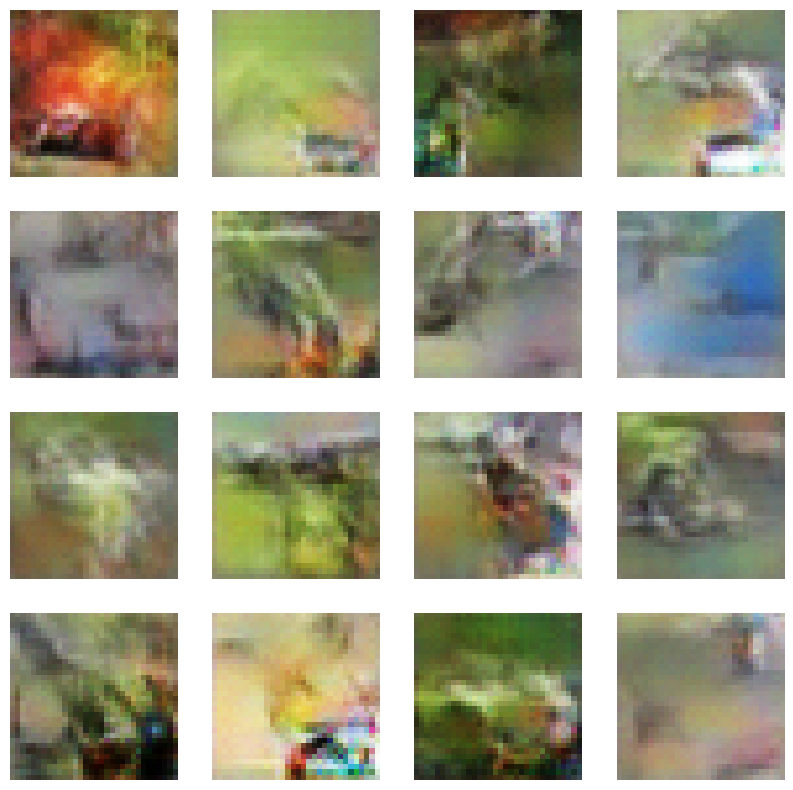

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and show images
def show_generated_images(generator, num_images=25, z_dim=100):
    generator.eval()  # Set the generator to evaluation mode

    # Generate random noise
    noise = torch.randn(num_images, z_dim, device=device)

    # Generate images from the noise
    with torch.no_grad():  # No need to track gradients
        fake_images = generator(noise)

    # Move images to the CPU and convert to numpy arrays
    fake_images = fake_images.cpu().numpy()

    # Rescale images from [-1, 1] to [0, 1]
    fake_images = (fake_images + 1) / 2

    # Plot the images
    fig, axs = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(10, 10))
    idx = 0
    for i in range(sqrt_num_images):
        for j in range(sqrt_num_images):
            axs[i,j].imshow(np.transpose(fake_images[idx], (1, 2, 0)))
            axs[i,j].axis('off')
            idx += 1
    plt.show()

num_images = 16
sqrt_num_images = int(np.sqrt(num_images))  # Assuming num_images is a perfect square
show_generated_images(generator, num_images=sqrt_num_images**2, z_dim=z_dim)